# Forecasting data from magnetometer stations with Prophet library.

## Install libraries.

In [2]:
# !pip install -r requirements.txt

## Import necessary libraries and set up the environment.

In [1]:
import prophet
from prophet import Prophet
from prophet.plot import plot_plotly, add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import plotly.offline as py
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

from sklearn.impute import KNNImputer

In [4]:
from etna.analysis import (cross_corr_plot, distribution_plot, plot_anomalies,
                           plot_anomalies_interactive, plot_backtest,
                           plot_correlation_matrix, plot_forecast)
from etna.analysis.outliers import (get_anomalies_density, get_anomalies_hist,
                                    get_anomalies_median,
                                    get_anomalies_prediction_interval)
from etna.transforms import (DateFlagsTransform, FilterFeaturesTransform,
                             HolidayTransform, LagTransform,
                             LinearTrendTransform, LogTransform, MeanTransform,
                             MedianOutliersTransform, SegmentEncoderTransform,
                             TimeSeriesImputerTransform)
from etna.datasets import TSDataset

Disable logger outputs from Prophet and cmdstanpy:

In [5]:
import logging

logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

logging.getLogger('prophet').setLevel(logging.WARNING)

## Data processing and review.

In [46]:
original_df = pd.read_csv("data/main_row_data.text", sep='\s+', na_values=99999.9)[['YYYY', 'MM', 'DD', 'HH', 'MM.1', 'SS', 'KEV_Y']]
original_df.rename(columns={"MM.1": "mm"}, inplace=True)
original_df.head()

,YYYY,MM,DD,HH,mm,SS,KEV_Y
0,1983,1,4,1,0,0,NaN
1,1983,1,4,2,0,0,NaN
2,1983,1,4,3,0,0,NaN
3,1983,1,4,4,0,0,NaN
4,1983,1,4,5,0,0,NaN


Fill missing dates

In [47]:
original_df.insert(0, 'date', original_df.apply(lambda x: datetime.datetime(int(x.YYYY), int(x.MM), int(x.DD), int(x.HH), int(x.mm), int(x.SS)), axis=1))
original_df.drop(columns=['YYYY', 'MM', 'DD', 'HH', 'mm', 'SS'], inplace=True)
original_df.set_index('date', inplace=True)
original_df = original_df.asfreq('H').reset_index()

In [48]:
original_df[original_df.KEV_Y.notnull()].head()

,date,KEV_Y
3969,1983-06-18 10:00:00,1292.5
3970,1983-06-18 11:00:00,1282.6
3971,1983-06-18 12:00:00,1268.7
3972,1983-06-18 13:00:00,1232.4
3973,1983-06-18 14:00:00,1284.1


Convert data to a format necessary for the Prophet library:

In [49]:
df = original_df.rename(columns={'date': 'ds',
                                'KEV_Y': 'y'})
df.ds = pd.to_datetime(df.ds, format='%Y-%m-%d %H:%M:%S')
df.head()

,ds,y
0,1983-01-04 01:00:00,NaN
1,1983-01-04 02:00:00,NaN
2,1983-01-04 03:00:00,NaN
3,1983-01-04 04:00:00,NaN
4,1983-01-04 05:00:00,NaN


Amount of data:

In [50]:
df.shape

(357359, 2)

What raw time series data looks like. Data before 2003 is not of very good quality, so we will not use it:

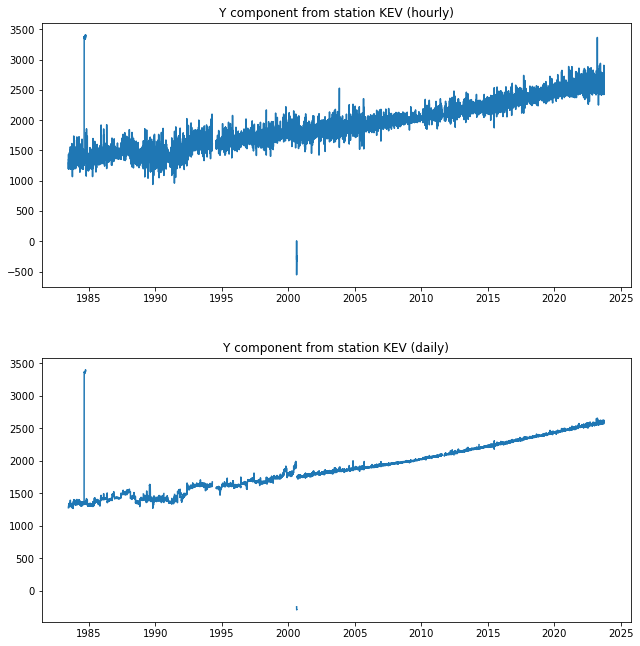

In [51]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))
fig.tight_layout(pad=5.0)
ax1.plot(df.ds, df.y)
ax1.set_title('Y component from station KEV (hourly)')
ax2.plot(df.resample('1D', on='ds').mean().reset_index().ds, df.resample('1D', on='ds').mean().y)
ax2.set_title('Y component from station KEV (daily)')
plt.show()

Let's look at the additional regressors:<br>
year,day,hr,min,sec: year, day of year, hour of day, minutes, seconds.<br>
Br : R-component of mag. field in RTN (nT).<br>
Bt : T-component of mag. field in RTN (nT).<br>
Bn : N-component of mag. field in RTN (nT).<br>
Bmag : <|B|> magnetic field magnitude (nT).<br>
Delta : RTN latitude.<br>
Lambda : RTN longitude.<br>
Bgse_x : X-component of mag. field in GSE (nT).<br>
Bgse_y : Y-component of mag. field in GSE (nT).<br>
Bgse_z : Z-component of mag. field in GSE (nT).<br>
Bgsm_x : X-component of mag. field in GSM (nT).<br>
Bgsm_y : Y-component of mag. field in GSM (nT).<br>
Bgsm_z : Z-component of mag. field in GSM (nT).<br>
dBrms : RMS values of underlying high-resolution measurements (nT).<br>
sigma_B : Variance of |B|, i.e. sqrt(<(|B|-<|B|>)^2>) (nT).<br>
pos_gse_x,y,z : Components of spacecraft position in GSE (km).<br>
pos_gsm_x,y,z : Components of spacecraft position in GSM (km).<br>
A value of -999.9 indicates bad or missing data.<br>
Link to dataset: https://izw1.caltech.edu/ACE/ASC/level2/lvl2DATA_MAG.html<br>

In [53]:
additional_df = pd.read_csv('/Users/pavlom/Desktop/ASCyv6iXk.txt', sep='\s+', na_values=[-999.9])

In [54]:
def create_date(year, day, hr):
      return (datetime.datetime(int(year), 1, 1) + datetime.timedelta(int(day) - 1)).replace(hour=int(hr))
additional_df.insert(0, 'date', additional_df.apply(lambda x: create_date(x.year, x.day, x.hr), axis=1))

In [55]:
additional_df.drop(columns=['year', 'day', 'hr', 'min', 'sec'], inplace=True)
additional_df.rename(columns={"date": "ds"}, inplace=True)
additional_df = additional_df[additional_df.ds > datetime.datetime.strptime('2003-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')].reset_index(drop=True)
df = df[df.ds > datetime.datetime.strptime('2003-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')].reset_index(drop=True)
additional_df = additional_df[additional_df.ds <= datetime.datetime.strptime('2023-05-05 23:00:00', '%Y-%m-%d %H:%M:%S')].reset_index(drop=True)
df = df.merge(additional_df, left_on=['ds'], right_on=['ds'], how='outer')

In [56]:
df.head()

,ds,y,Br,Bn,Bmag,Delta,Lambda,Bgse_x,Bgse_y,Bgse_z,...,Bgsm_y,Bgsm_z,dBrms,sigma_B,pos_gse_x,pos_gse_y,pos_gse_z,pos_gsm_x,pos_gsm_y,pos_gsm_z
0,2003-01-01 01:00:00,1824.7,0.479,-0.899,6.655,-9.426,275.070,-0.483,5.256,-1.513,...,5.451,-0.229,3.735,0.175,1543900.0,-76283.0,120490.0,1543900.0,-102500.0,99146.0
1,2003-01-01 02:00:00,1823.6,-0.070,-0.041,6.747,-0.445,269.247,0.067,5.305,-0.655,...,5.339,0.407,4.099,0.244,1543900.0,-76613.0,120610.0,1543900.0,-99065.0,102960.0
2,2003-01-01 03:00:00,1814.7,-2.663,2.769,7.175,23.305,245.517,2.662,6.130,2.076,...,5.749,2.977,1.549,0.143,1543800.0,-76943.0,120720.0,1543800.0,-94378.0,107640.0
3,2003-01-01 04:00:00,1816.8,-2.277,1.525,7.443,12.159,251.240,2.274,6.835,0.744,...,6.713,1.402,1.692,0.109,1543800.0,-77273.0,120840.0,1543800.0,-88726.0,112700.0
4,2003-01-01 05:00:00,1816.4,-0.641,-1.269,7.167,-10.986,264.375,0.636,6.315,-2.007,...,6.382,-1.732,2.638,0.298,1543800.0,-77602.0,120960.0,1543800.0,-82587.0,117610.0


Vizualize some additional regressors:

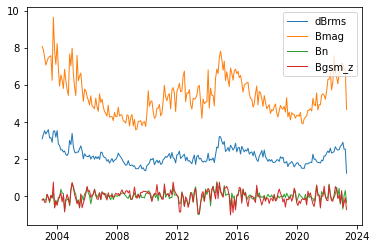

In [71]:
plt.plot(df.resample('1MS', on='ds').mean().dBrms, label='dBrms', linewidth=1)
plt.plot(df.resample('1MS', on='ds').mean().Bmag, label='Bmag', linewidth=1)
plt.plot(df.resample('1MS', on='ds').mean().Bn, label='Bn', linewidth=1)
plt.plot(df.resample('1MS', on='ds').mean().Bgsm_z, label='Bgsm_z', linewidth=1)
plt.legend()
plt.show()

Train and test split:

In [74]:
train_size = int(df.shape[0] * 0.8)
test_size = df.shape[0] - train_size

df_train = df[:train_size].copy(deep=True)
df_val = df[train_size:int(train_size + test_size / 2)].copy(deep=True)
df_test = df[int(train_size + test_size / 2):].copy(deep=True)

df_train.shape, df_val.shape, df_test.shape

((145688, 21), (18211, 21), (18212, 21))

In [58]:
def fill_missing_values(dataframe, method):
    dataframe = dataframe.copy(deep=True)
    if method == 'default':
        return dataframe
    # fill with mean.
    if method == 'mean':
        return dataframe.fillna(dataframe.mean(numeric_only=True).round(1))
    # fill with median.
    if method == 'median':
        return dataframe.fillna(dataframe.median(numeric_only=True).round(1))
    # if there are nan left, fill with bfill.
    if method == 'ffill':
        return dataframe.fillna(method=method).fillna(method='bfill')
    # filling occurs with next values.
    # if there are nan left, fill with ffill.
    if method == 'bfill':
        return dataframe.fillna(method=method).fillna(method='ffill')
    # fill with backward interpolation.
    # if there are nan left, fill with forward.
    if method == 'interpolate_backward':
        return dataframe.apply(lambda col: col.interpolate(method ='linear', limit_direction ='backward')
                                              .interpolate(method ='linear', limit_direction ='forward') if col.name != "ds" else col)
    # fill with forward interpolation.
    # if there are nan left, fill with backward.
    if method == 'interpolate_forward':
        return dataframe.apply(lambda col: col.interpolate(method ='linear', limit_direction ='forward')
                                              .interpolate(method ='linear', limit_direction ='backward') if col.name != "ds" else col)
    # fill with knn method.
    if method == 'knn':
        imputer = KNNImputer(n_neighbors=15)
        dataframe = dataframe.apply(lambda col: imputer.fit_transform(col.to_numpy().reshape(-1, 1)).T[0] if col.name != "ds" else col)
        return dataframe

    return dataframe

Function for smape metric:

In [15]:
def calc_smape(actual, predicted) -> float: 
  
    # Convert actual and predicted to numpy 
    # array data type if not already 
    if not all([isinstance(actual, np.ndarray),  
                isinstance(predicted, np.ndarray)]): 
        actual, predicted = np.array(actual), np.array(predicted) 
  
    return np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual)) / 2) ) * 100

Function that evaluates model and finds mse, mape and smape metrics:

In [90]:
def evaluate_model(model, df_test):
    future = df_test
    forecast = model.predict(future)

    predictions = forecast.iloc[-len(df_test):]['yhat']
    actuals = df_test['y']

    mse = round(mean_squared_error(actuals, predictions), 4)
    mape = round(mean_absolute_percentage_error(actuals, predictions) * 100, 4)
    smape = round(calc_smape(actuals, predictions), 4)

    return mse, mape, smape, list(actuals), list(predictions)

Find best method (by mse metric) for filling missing values:

In [28]:
methods = ['default', 'mean', 'median', 'ffill', 'bfill', 'interpolate_backward', 'interpolate_forward', 'knn']
mses = {"mse":[]}

for method in tqdm(methods, position=0, leave=True):
    # Replace nan values.
    no_nan_df = fill_missing_values(df_train, method)
    no_nan_df.reset_index(inplace=True)
    model = Prophet()
    model.fit(no_nan_df)

    mse, _, _, _, _ = evaluate_model(model, df_val)
    mses['mse'] += [mse]

print(f"\nBest method: {methods[np.argmin(mses['mse'])]}")
fill_mv_results = pd.DataFrame(mses)
fill_mv_results.insert(0, 'methods', methods)
fill_mv_results.sort_values("mse").reset_index(drop=True)

100%|████████████████████████████████████████████| 8/8 [14:34<00:00, 109.35s/it]


Best method: ffill


,methods,mse
0,ffill,632.418074
1,interpolate_backward,638.378174
2,interpolate_forward,638.378174
3,default,639.935589
4,bfill,643.573646
5,knn,830.496093
6,mean,830.776875
7,median,851.570975


Fill missing values in train, val and test data:

In [75]:
df_train = fill_missing_values(df_train, method='ffill')
df_val = fill_missing_values(df_val, method='ffill')
df_test = fill_missing_values(df_test, method='ffill')

df_train.y.isna().sum(), df_val.y.isna().sum(), df_test.y.isna().sum()

(0, 0, 0)

Normalizing data:

In [76]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_train.y = scaler.fit_transform(np.array(df_train.y).reshape(-1, 1)).T[0]
df_val.y = scaler.transform(np.array(df_val.y).reshape(-1, 1)).T[0]
df_test.y = scaler.transform(np.array(df_test.y).reshape(-1, 1)).T[0]

In [77]:
def plot_train_val_test():
    plt.figure(figsize=(10,5))

    plt.plot(df_train.ds, df_train.y, color='b', label='train', linewidth=0.5)
    plt.plot(df_val.ds, df_val.y, color='c', label='val', linewidth=0.5)
    plt.plot(df_test.ds, df_test.y, color='r', label='test', linewidth=0.5)

    plt.xlabel("Date", fontsize=14)
    plt.ylabel("KEV_Y")
    plt.title("Train, val and test data", fontsize=14)

    plt.legend()

    plt.show()

How data with outliers looks like:

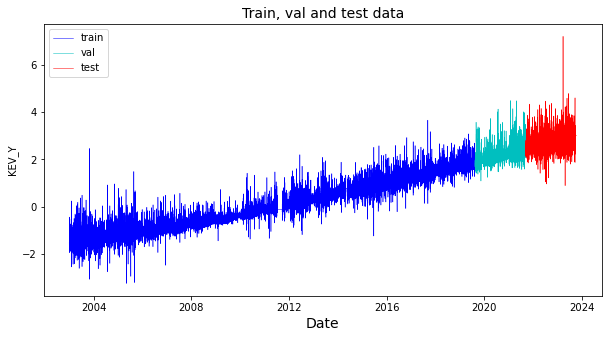

In [78]:
plot_train_val_test()

Let's look at model performance on data with outliers:

In [272]:
model_with_outliers = Prophet()
model_with_outliers.fit(df_train)
mse, mape, smape, actuals, predictions = evaluate_model(model_with_outliers, df_val)

print(f'mse: {mse}, mape: {mape}, smape: {smape}')

mse: 0.0202, mape: 3.4157, smape: 3.4825


Now we will try to find best algorithm for outlier detection.<br>
Firstly we bring the dataset into a form convenient for the etna library

In [79]:
df_etna = df_train.copy(deep=True)
df_etna["timestamp"] = df_etna["ds"]
df_etna["target"] = df_etna["y"]
df_etna.drop(columns=["ds", "y"], inplace=True)
df_etna["segment"] = "main"

df_etna = TSDataset.to_dataset(df_etna)
ts_etna = TSDataset(df_etna, freq="H")

df_etna.head()

segment               main                                                   \
feature             Bgse_x Bgse_y Bgse_z Bgsm_x Bgsm_y Bgsm_z   Bmag     Bn   
timestamp                                                                     
2003-01-01 01:00:00 -0.483  5.256 -1.513 -0.483  5.451 -0.229  6.655 -0.899   
2003-01-01 02:00:00  0.067  5.305 -0.655  0.067  5.339  0.407  6.747 -0.041   
2003-01-01 03:00:00  2.662  6.130  2.076  2.662  5.749  2.977  7.175  2.769   
2003-01-01 04:00:00  2.274  6.835  0.744  2.274  6.713  1.402  7.443  1.525   
2003-01-01 05:00:00  0.636  6.315 -2.007  0.636  6.382 -1.732  7.167 -1.269   

segment                                                                  \
feature                 Br   Delta   Lambda  dBrms  pos_gse_x pos_gse_y   
timestamp                                                                 
2003-01-01 01:00:00  0.479  -9.426  275.070  3.735  1543900.0  -76283.0   
2003-01-01 02:00:00 -0.070  -0.445  269.247  4.099  1543900.0  -76613.0   
2003-01-01 03:00:00 -2.663  23.305  245.517  1.549  1543800.0  -76943.0   
2003-01-01 04:00:00 -2.277  12.159  251.240  1.692  1543800.0  -77273.0   
2003-01-01 05:00:00 -0.641 -10.986  264.375  2.638  1543800.0  -77602.0   

segment                                                                         
feature             pos_gse_z  pos_gsm_x pos_gsm_y pos_gsm_z sigma_B    target  
timestamp                                                                       
2003-01-01 01:00:00  120490.0  1543900.0 -102500.0   99146.0   0.175 -1.513407  
2003-01-01 02:00:00  120610.0  1543900.0  -99065.0  102960.0   0.244 -1.519636  
2003-01-01 03:00:00  120720.0  1543800.0  -94378.0  107640.0   0.143 -1.570034  
2003-01-01 04:00:00  120840.0  1543800.0  -88726.0  112700.0   0.109 -1.558142  
2003-01-01 05:00:00  120960.0  1543800.0  -82587.0  117610.0   0.298 -1.560407

In [22]:
def find_best_outlier_detector(param_grid, algorithm):
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    metrics = {"mape":[], "mse":[], "smape":[]}

    for params in tqdm(all_params, position=0, leave=True):
        m = Prophet()

        anomaly_dict = algorithm(ts_etna, **params)

        m.fit(df_train.loc[~df_train.ds.isin(anomaly_dict['main'])].reset_index())

        mse, mape, smape, _, _ = evaluate_model(m, df_val)
        metrics['mse'] += [mse]
        metrics['mape'] += [mape]
        metrics['smape'] += [smape]

    best_params = all_params[np.argmin(metrics['mape'])]
    print("\nBest params: ", best_params)

    outliers_detection_results = pd.DataFrame(all_params)
    outliers_detection_results = outliers_detection_results.join(pd.DataFrame.from_dict(metrics))
    return outliers_detection_results.sort_values("mape").reset_index(drop=True)

1. Method <b>based on deviation from median values calculated over a window</b>.<br>

In [136]:
param_grid = {
    'window_size': [500, 1000, 1500, 2000, 2500, 3000, 3500],
    'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9]
}

find_best_outlier_detector(param_grid, algorithm=get_anomalies_median).head(20)

100%|█████████████████████████████████████████| 63/63 [1:36:47<00:00, 92.18s/it]


Best params:  {'window_size': 500, 'alpha': 2}


,window_size,alpha,mape,mse,smape
0,500,2,3.323581,0.021732,3.42
1,1000,3,3.339486,0.021046,3.42
2,2500,3,3.339615,0.021053,3.43
3,1500,3,3.340035,0.021060,3.43
4,2000,3,3.343313,0.021102,3.43
5,3500,3,3.344395,0.021096,3.43
6,3000,3,3.346684,0.021117,3.43
7,500,3,3.346798,0.021081,3.43
8,3000,4,3.361025,0.020668,3.44
9,2000,4,3.361939,0.020663,3.44


2. <b>Density-based</b> method.

In [143]:
param_grid = {
    'window_size': [100, 200, 300, 400, 500],
    'distance_coef': [1, 2, 3],
    'n_neighbors': [1, 2, 3, 4]
}

find_best_outlier_detector(param_grid, algorithm=get_anomalies_density).head(20)

100%|████████████████████████████████████████| 60/60 [1:40:21<00:00, 100.35s/it]


Best params:  {'window_size': 100, 'distance_coef': 1, 'n_neighbors': 4}


,window_size,distance_coef,n_neighbors,mape,mse,smape
0,100,1,4,3.410730,0.020205,3.48
1,100,1,1,3.411559,0.020164,3.48
2,500,1,3,3.411695,0.020156,3.48
3,300,1,4,3.411742,0.020183,3.48
4,400,1,3,3.412022,0.020165,3.48
5,200,1,4,3.412396,0.020212,3.48
6,200,1,3,3.412427,0.020187,3.48
7,500,1,4,3.412475,0.020187,3.48
8,400,1,4,3.412475,0.020187,3.48
9,500,1,2,3.413032,0.020195,3.48


Vizualize detected outliers for best method:

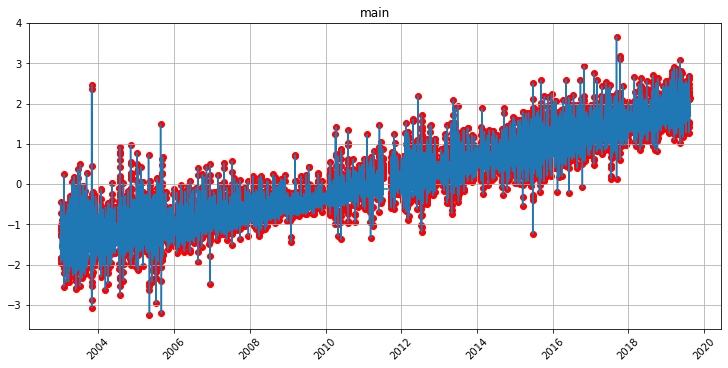

In [80]:
anomaly_dict = get_anomalies_median(ts_etna, window_size=500, alpha=2)
plot_anomalies(ts_etna, anomaly_dict)

If you zoom in on the data, you can see that too much data is being deleted. This is not very good.

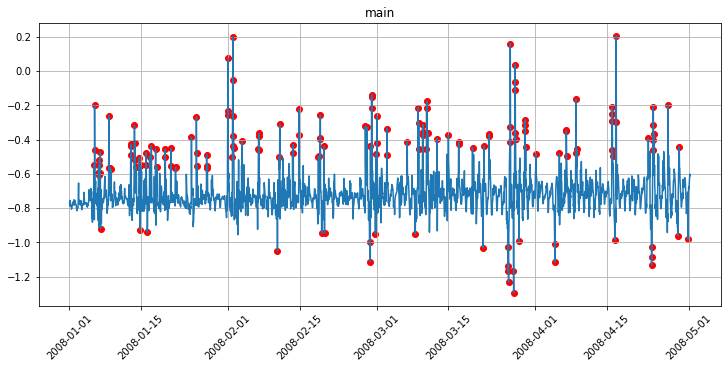

In [81]:
plot_anomalies(ts_etna, anomaly_dict, start='2008-01-01 01:00:00', end='2008-05-01 05:00:00')

Let's try to manually go through the parameters to remove outliers

In [25]:
segment = "main"
method = get_anomalies_median
params_bounds = {"window_size": (100, 10000, 50), "alpha": (1, 10, 0.5)}
plot_anomalies_interactive(ts=ts_etna, segment=segment, method=method, params_bounds=params_bounds)

interactive(children=(IntSlider(value=100, continuous_update=False, description='window_size', max=10000, min=…

It really seems like it's getting better. So we will use this parameters further

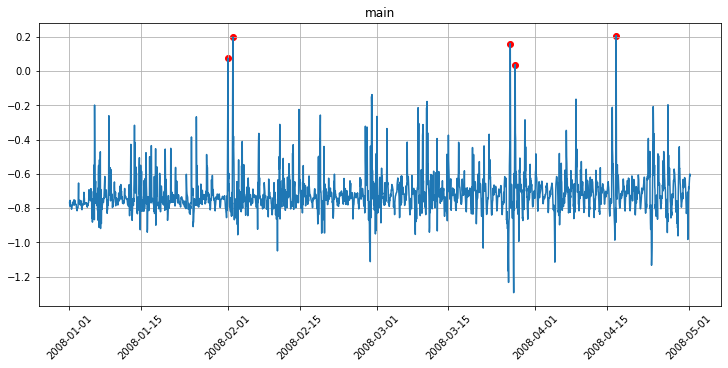

In [82]:
anomaly_dict_final = get_anomalies_median(ts_etna, window_size=5200, alpha=7.5)
plot_anomalies(ts_etna, anomaly_dict_final, start='2008-01-01 01:00:00', end='2008-05-01 05:00:00')

Drop outliers from df_train:

In [83]:
df_train.y = df_train.y.mask(df_train.ds.isin(anomaly_dict_final['main']))

Number of detected outliers:

In [84]:
print('Number of detected outliers: ' + str(len(anomaly_dict_final['main'])))

Number of detected outliers: 150


Get model performance after dropping outliers:

In [290]:
m = Prophet()
m.fit(df_train)
mse, mape, smape, actuals, predictions = evaluate_model(m, df_val)

print(f'mse: {mse}, mape: {mape}, smape: {smape}')

mse: 0.0202, mape: 3.4014, smape: 3.4674


Visualize train and test data without outliers:

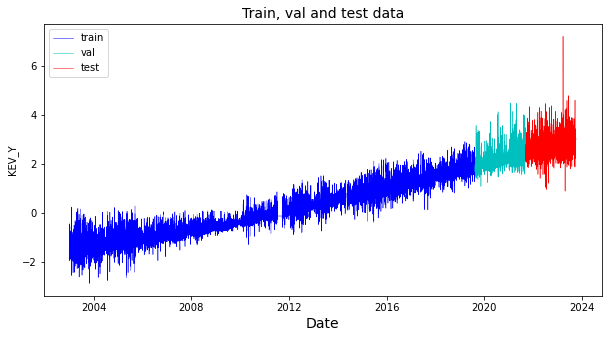

In [85]:
plot_train_val_test()

## Model training.

Let's look at model performance by changing chengepoint_range.

In [308]:
metrics = {"mape":[], "mse":[], "smape":[]}
crs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for cr in tqdm(crs, position=0, leave=True):
    m = Prophet(changepoint_range=cr)
    m.fit(df_train)

    mse, mape, smape, _, _ = evaluate_model(m, df_val)
    metrics['mse'] += [mse]
    metrics['mape'] += [mape]
    metrics['smape'] += [smape]


print(f"\nBest changepoint_range: {crs[np.argmin(metrics['mape'])]}")
chose_changepoint_range_results = pd.DataFrame({"changepoint_ranges": crs})
chose_changepoint_range_results = chose_changepoint_range_results.join(pd.DataFrame.from_dict(metrics))
chose_changepoint_range_results.sort_values("mape").reset_index(drop=True)

100%|█████████████████████████████████████████████| 9/9 [11:47<00:00, 78.58s/it]


Best changepoint_range: 0.8


,changepoint_ranges,mape,mse,smape
0,0.8,3.4014,0.0202,3.4674
1,0.7,3.4029,0.0203,3.4707
2,0.6,3.5443,0.0214,3.6433
3,0.5,3.5563,0.0215,3.6569
4,0.4,3.7545,0.0227,3.8776
5,0.9,3.7760,0.0229,3.8986
6,0.3,4.1820,0.0251,4.3413
7,0.2,5.1468,0.0307,5.3776
8,0.1,6.8380,0.0416,7.1957


The changepoint_range parameter defaults to 0.8. So we won't change it in the future.

Now let's train model with additional regressors. Get all combinations from additional regressors:

In [87]:
variables_list = ['Bmag', 'dBrms', 'Delta', 'Bn', 'Br', 'Lambda', 'Bgsm_z', 'sigma_B']

list_combinations = []
for i in range(len(variables_list) + 1):
    list_combinations += list(itertools.combinations(variables_list, i))
list_combinations[-10:]

[(), ('Bmag',), ('dBrms',), ('Bmag', 'dBrms')]

In [97]:
metrics = {"mape":[], "mse":[], "smape":[]}

for combination in tqdm(list_combinations):
    m = Prophet()
    for regressor in combination:
        m.add_regressor(regressor)
    m.fit(df_train)
    mse, mape, smape, _, _ = evaluate_model(m, df_val[['ds', 'y'] + list(combination)])
    metrics['mse'] += [mse]
    metrics['mape'] += [mape]
    metrics['smape'] += [smape]

best_regressors = all_params[np.argmin(metrics['mape'])]
print("\nBest params: ", best_regressors)

best_regressors_results = pd.DataFrame(list_combinations)
best_regressors_results = best_regressors_results.join(pd.DataFrame.from_dict(metrics))
best_regressors_results.sort_values("mape").reset_index(drop=True)

100%|█████████████████████████████████████████████| 4/4 [06:06<00:00, 91.74s/it]


Best params:  {'n_changepoints': 25}


,0,1,mape,mse,smape
0,None,None,3.4014,0.0202,3.4674
1,dBrms,None,3.4106,0.0203,3.4777
2,Bmag,None,3.4173,0.0201,3.4790
3,Bmag,dBrms,3.4176,0.0202,3.4806


Automatic hyperparameter tuning by MSE metric:

In [34]:
metrics = {"mape":[], "mse":[], "smape":[]}

# Set up parameter grid
param_grid = {
#     'changepoint_prior_scale': [0.1, 1, 5, 10],
#     'seasonality_prior_scale': [8, 9, 10, 11, 12],
#     'seasonality_mode': ['additive', 'multiplicative'],
    'n_changepoints' : [25, 50, 100, 150],
}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

for params in tqdm(all_params, position=0, leave=True):
    # Fit a model using one parameter combination
    m = Prophet(**params)
    m.fit(df_train)

    mse, mape, smape, _, _ = evaluate_model(m, df_val)
    metrics['mse'] += [mse]
    metrics['mape'] += [mape]
    metrics['smape'] += [smape]

best_params = all_params[np.argmin(metrics['mape'])]
print("\nBest params: ", best_params)

tuning_results = pd.DataFrame(all_params)
tuning_results = tuning_results.join(pd.DataFrame.from_dict(metrics))
tuning_results.sort_values("mape").reset_index(drop=True)

100%|████████████████████████████████████████████| 4/4 [11:28<00:00, 172.18s/it]


Best params:  {'n_changepoints': 25}


,n_changepoints,mape,mse,smape
0,25,3.4014,0.0202,3.4674
1,150,3.4022,0.0203,3.4689
2,50,3.4029,0.0203,3.4697
3,100,3.4037,0.0203,3.4717


In [33]:
Prophet?

Fit model with tuned parameters:

In [28]:
tuned_model = Prophet(changepoint_range=0.4, changepoint_prior_scale=0.005, seasonality_prior_scale=10, seasonality_mode='additive')
tuned_model.fit(df_train)

mse, mape, smape, actuals, predictions = evaluate_model(tuned_model, df_test)

print(f'mse: {mse}, mape: {mape}, smape: {smape}')

mse: 0.37156338662120303, mape: 55.985011979651425, smape: 19.941564792284588


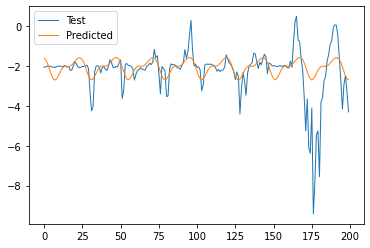

In [31]:
plt.plot(actuals[-5000:-4800], label='Test', linewidth=1)
plt.plot(predictions[-5000:-4800], label='Predicted', linewidth=1)
plt.legend()
plt.show()

In [ ]:
from prophet.serialize import model_to_json, model_from_json

with open('serialized_model.json', 'w') as fout:
    fout.write(model_to_json(tuned_model))  # Save model